![air-paradis](https://drive.google.com/uc?id=1T26mpOAUvJP700W4m8bjfYCLmDYVcyJL)

# <font color=red><center>**AIR PARADIS**</center></font>

**Air Paradis** is an airline company that wants to use AI (*Artificial Intelligence*) to **detect Bad Buzz associated with its brand** in online public tweets.

**As AI engineer for Marketing Intelligence Consulting**, we will dive into **NLP** (*Natural Language Processing*) techniques to serve Air Paradis' purpose.

Indeed, NLP allows a machine to **understand and process human language**. It will help us to solve this **text classification goal** and **detect sentiment** (positive or negative) from these tweets.

We will deploy our best **DETECT SENTIMENT solution** through <font color=salmon>**Microsoft Azure Machine Learning plateform**</font> (***MS Azure ML***).

<br>

Therefore, we will structure the project as follows:

<br>

| **Services / Tools** | **Objective** | **Available notebook** |
| :-- | :-- | :-- |
| **Google Colab and Python libraries** | Build quality of data by pre-processing the tweets text | Notebook N°1 |
| **Google Colab / MS Azure Cognitive Services API** | Use Text Analytics > Sentiment API | Notebook N°2 |
| **Python Script / MS Azure ML Studio > Designer** | Use "Drag-and-Drop" pipeline with no code in Azure ML Studio| Notebook N°3 |
| **Tensorflow-Keras / Google Colab PRO with GPU/TPU** | Train and evaluate advanced models | **<font color=green>Notebook N°4</font>** |
|**MS Azure ML Cloud > Models**| Deploy the best solution in MS Azure WebService | Notebook N°5 |

<br>

This notebook is dedicated to 4th task : **build advanced models with TensorFlow/Keras and words embedding, train and evaluate to pick the best one to be deployed**.

# <font color=brown><center>**NOTEBOOK 4<br>SENTIMENT DETECTION WITH TENSORFLOW / KERAS<br>AND WORDS EMBEDDINGS**</center></font>

In this notebook, we will use:
- Tensorflow with Keras as framework;
- Word Embedding as language modeling technique.

# <font color=salmon>PART 1 - PREPARE THE TWEET DATA</font>

## <font color=green>P1.1 - Load libraries and configure GPU</font>

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import libraries
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from scipy.stats import iqr
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Dense
from tensorflow.keras.layers import Dropout, SpatialDropout1D
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

%matplotlib inline

# Set general config
pd.set_option("display.max_colwidth", 200)
src_folder = Path('/content/drive/MyDrive/OC_IA/P07')
model_folder = Path(src_folder / 'all_models')

In [ ]:
import tensorflow as tf

# Check the activated GPU
print('Tensorflow version: ',tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version:  2.7.0
Found GPU at: /device:GPU:0


In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import os
from datetime import datetime

# Create TensorBoard callback
logdir = os.path.join(src_folder / 'logs', datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
# Clear any logs from previous runs
!rm -rf src_folder/logs

In [ ]:
# import tensorflow as tf

# Detect TPU
# try:
  # tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  # print('Running on TPU - OK')
# except ValueError:
  # raise BaseException('ERROR: Not connected to a TPU runtime')

# tf.config.experimental_connect_to_lmuster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

## <font color=green>P1.2 - Load Dataset and choose text to use</font>

In [ ]:
# # Import data
# df = pd.read_csv(src_folder / 'p7_01b_final_df.csv')
df = pd.read_csv(src_folder / 'p7_02_sample_df.csv')

print(df.shape)
df.head()

(1600, 5)


,tweet,text_cl,text_lm,text_sm,sentiment
0,@ROzyROckz haha no married here good guys come a dime a dozen these days,user no married here good guys come a dime a dozen these days,user no married good guy come dime dozen day,user no marri good guy come dime dozen day,0
1,watchin' news... so sad the ppl in my country do not care about that proplem in puno... ppl are dying,watchin news so sad the ppl in my country do not care about that proplem in puno ppl are dying,watchin news sad ppl country not care proplem puno ppl dying,watchin news sad ppl countri not care proplem puno ppl die,0
2,"@paul_stewart &amp; @holycowcreative i'd LOVE to go to this http://tinyurl.com/dfcbek, but i'll be out of town that week.",user user i would love to go to this url but i will be out of town that week,user user love go url town week,user user love go url town week,0
3,I wish I was good at making decisions,i wish i was good at making decisions,wish good making decision,wish good make decis,0
4,Got a new puppy today and am halfway iffy cuz of my baby pup I lost,got a new puppy today and am halfway iffy cuz of my baby pup i lost,got new puppy today halfway iffy cuz baby pup lost,got new puppi today halfway iffi cuz babi pup lost,0


As our dataframe allows us to choose, we can use either **simple cleaned tweets** or **lemmatized tweets** for all the models.

For this time, we use simple **cleaned tweets**.

In [ ]:
# Choose the processed text to use
# PROCESSED_TEXT = 'clean_tweet' #@param["clean_tweet", "lemma_tweet"]
PROCESSED_TEXT = 'text_lm' #@param["text_cl", "text_sm", "text_lm"]

# Create new features: word count
df['word_count'] = df[PROCESSED_TEXT].str.split().str.len()

# Check of some words statistics
w_min = df.word_count.min()
w_max = df.word_count.max()
w_mean = df.word_count.mean()
w_median = df.word_count.median()
w_iqr = df.word_count.quantile(0.75)+ 1.5*iqr(df.word_count)

print('# Min={} - Mean={} - Median={} - IQR={} - Max={}'.format(w_min,
                                                                round(w_mean,0),
                                                                round(w_median,0),
                                                                round(w_iqr,0),
                                                                w_max))

# Min=2 - Mean=8.0 - Median=7.0 - IQR=19.0 - Max=20


We can see that the **interquartile range** considers that tweets with more than **36 words** are "outliers". We can choose this measure as basis for our maximum length of tweets.

In [ ]:
# Filter on necessary columns and rename
sample_df = df[[PROCESSED_TEXT, 'sentiment']]
sample_df.rename(columns={sample_df.columns[0]:'text'}, inplace=True)
sample_df.head()

,text,sentiment
0,user no married good guy come dime dozen day,0
1,watchin news sad ppl country not care proplem puno ppl dying,0
2,user user love go url town week,0
3,wish good making decision,0
4,got new puppy today halfway iffy cuz baby pup lost,0


## <font color=green>P1.3 - Create a sample</font>

In [ ]:
# # Choose a number of samples to return by sentiment
# N = 200000 #@param ["200000", "400000"] {type:"raw"}

# # Create a sample of DF
# sample_df = sample_df.groupby('sentiment').apply(lambda x: x.sample(n=N,
#                                                              random_state=42))

# sample_df.reset_index(drop=True, inplace=True)
# print(sample_df.shape)
# sample_df.head()

In [ ]:
# Check target distribution
sample_df.sentiment.value_counts()

1    800
0    800
Name: sentiment, dtype: int64

In [ ]:
# Save to CSV file
sample_df.to_csv(src_folder / 'p7_04_sample_lm_df.csv', index=False)

## <font color=green>P1.4 - Configure all common variables of models</font>

In [ ]:
#@title Configure all modeling variables

# Define the vocabulary size to be used in Tokenizer
VOCAB_SIZE = 5000 #@param ["5000", "10000", "25000", "50000"] {type:"raw"}

# Maximum number of words in a sequence
# Create word sequences of equal lenght:
# Truncated if longer, padded (with 0) if shorter
MAX_LEN = 19 #@param ["19", "37"] {type:"raw"}

# Define embedding dimensions
EMBEDDING_DIM = 256 #@param ["128", "256", "512"] {type:"raw"}

# Select Dropout value
DROP_OUT = 0.5 #@param ["0.3", "0.5"] {type:"raw"}

# Select learning rate
# for Optimizer
OPTIM_LR = 0.001 #@param ["0.001", "0.0001"] {type:"raw"}
# for regularizer
REGUL_LR = 0.001 #@param ["0.001", "0.0001"] {type:"raw"}

# Define model metrics
#AUC: Computes the approximate AUC (Area under the curve) via a Riemann sum
#Accuracy: Calculates how often predictions equal labels
# TN: Calculates the number of true negatives
FP = tf.keras.metrics.FalsePositives(name='fp')
METRICS = ['acc', 'AUC', FP]

# Set model variables
NUM_EPOCHS = 5 #@param ["5", "10", "20"] {type:"raw"}

# Select batchsize
BATCH_SIZE = 100 #@param ["50", "100", "250"] {type:"raw"}

## <font color=green>P1.5 - Split data in Train and Test sets</font>

In [ ]:
# Split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(sample_df.text,
                                                    sample_df.sentiment,
                                                    test_size=0.2,
                                                    random_state=42)

# Display shape
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])

# Train data samples: 1280
# Test data samples: 320


In [ ]:
# Save to csv file
X_train.to_csv(src_folder / 'p7_04_X_train_lm.csv', index=False)
y_train.to_csv(src_folder / 'p7_04_y_train_lm.csv', index=False)
X_test.to_csv(src_folder / 'p7_04_X_test_lm.csv', index=False)
y_test.to_csv(src_folder / 'p7_04_y_test_lm.csv', index=False)

## <font color=green>P1.6 - Vectorize data and pad the sequences</font>

> **Why we vectorize the text?**

Machine learning models take **vectors** (*arrays of numbers*) as input. When working with text, the first thing we must do is to choose strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model.

Here, we tokenize the tweets using the <code>**Tokenizer**</code> provided by **Keras**. We use the Train set only to build a **vocabulary of tokens**, and use them to convert all the tweets into a (padded) sequence of tokens of the same length.

***Note***: 0 is a reserved index that won't be assigned to any word.

In [ ]:
# Vectorize (convert words to numbers) with Keras tokenizer
tk = Tokenizer(num_words=VOCAB_SIZE)
tk.fit_on_texts(X_train)

# Get the dictionary of vocab created by Keras
word_index = tk.word_index
print('Word Index length: ', len(word_index), '\n')

# Convert texts to sequences
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

# Zero pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

Word Index length:  3194 



## <font color=green>P1.7 - Create validation set</font>

In [ ]:
# Add validation data
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_pad,
                                                                      y_train,
                                                                      test_size=0.2,
                                                                      random_state=42)

print('# Shape of validation set:', X_train_emb.shape)
print('# Shape of validation set:', X_valid_emb.shape)

# Shape of validation set: (1024, 19)
# Shape of validation set: (256, 19)


## <font color=green>P1.8 - Create helper functions</font>

In [ ]:
# title Function to plot learning curves
def std_learning_curves(history, title,
                        NUM_EPOCHS,
                        auc, val_auc,
                        acc, val_acc,
                        loss, val_loss):
    
    plt.figure(figsize=(5,10))

    plt.subplot(3, 1, 1)
    plt.plot(auc, label='Training AUC')
    plt.plot(val_auc, label='Validation AUC')
    plt.legend(loc='lower right')
    plt.xlabel('Epochs')
    plt.xticks(np.arange(NUM_EPOCHS))
    plt.ylabel('AUC')
    plt.title('Training and Validation AUC')

    plt.subplot(3, 1, 2)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel('Epochs')
    plt.xticks(np.arange(NUM_EPOCHS))
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 1, 3)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.xticks(np.arange(NUM_EPOCHS))
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
# title Function to plot confusion matrix
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.title(title, fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# <font color=salmon>PART 2 - MODEL1 (*BASELINE*): **Simple RNN and Embeddings**</font>

> **What are RNNs?**

**Recurrent Neural Networks (RNN)** are a type of Neural Network where the output from previous step are fed as input to the current step.

In traditional neural networks, all the inputs and outputs are independent of each other : RNN is powerful for modeling sequence data such as time series or natural language.

In NLP (*Natural Language Processing*), we need either to predict the next word of a sentence, or to understand the context/meaning of a sentence for classification purpose: schematically, RNN can remember (or keep in memory) the previous words.

RNN work fine when dealing with *short-term* dependencies.

> **What are Word embeddings?**

**Word embeddings** are a way of representing words (or text data), in which similar words have a similar encoding. An embedding is a dense vector of floating point values : the unique parameter we need to specify is the length of this vector.

## <font color=green>2.1 - Create the model structure</font>

In [ ]:
# Add sequential model
base_model = Sequential(name='base_model')
base_model.add(Embedding(input_dim=VOCAB_SIZE,
                         output_dim=EMBEDDING_DIM,
                         input_length=MAX_LEN))
base_model.add(SpatialDropout1D(DROP_OUT))
base_model.add(SimpleRNN(128, dropout=DROP_OUT))
base_model.add(Dropout(DROP_OUT))
base_model.add(Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(REGUL_LR)))
base_model.add(Dropout(DROP_OUT))
base_model.add(Dense(1, activation='sigmoid'))
base_model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 19, 256)           1280000   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 19, 256)          0         
 lDropout1D)                                                     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               49280     
                                                                 
 dropout_45 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_46 (Dropout)        (None, 64)                0         
                                                        

## <font color=green>2.2 - Compile and fit</font>

In [ ]:
# Compile the model
base_model.compile(loss='binary_crossentropy',
                   optimizer=Adam(learning_rate=OPTIM_LR),
                   metrics=METRICS)

# Fit the model
start = time()
base_history = base_model.fit(X_train_emb, y_train_emb,
                              epochs=NUM_EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(X_valid_emb, y_valid_emb),
                              callbacks=[tensorboard_callback])
fit_time = (time()-start)

# Save the model
base_model.save(model_folder/'base_model_lm.h5')

Epoch 1/5
11/11 [==============================] - 2s 77ms/step - loss: 0.8042 - acc: 0.4912 - auc: 0.4932 - fp: 238.0000 - val_loss: 0.7710 - val_acc: 0.5195 - val_auc: 0.5369 - val_fp: 101.0000
Epoch 2/5
11/11 [==============================] - 0s 39ms/step - loss: 0.7894 - acc: 0.4941 - auc: 0.5126 - fp: 270.0000 - val_loss: 0.7736 - val_acc: 0.5312 - val_auc: 0.4844 - val_fp: 80.0000
Epoch 3/5
11/11 [==============================] - 0s 38ms/step - loss: 0.7651 - acc: 0.5537 - auc: 0.5732 - fp: 224.0000 - val_loss: 0.7687 - val_acc: 0.5195 - val_auc: 0.5258 - val_fp: 83.0000
Epoch 4/5
11/11 [==============================] - 0s 37ms/step - loss: 0.7583 - acc: 0.5625 - auc: 0.5944 - fp: 182.0000 - val_loss: 0.7647 - val_acc: 0.5469 - val_auc: 0.5434 - val_fp: 84.0000
Epoch 5/5
11/11 [==============================] - 0s 38ms/step - loss: 0.7436 - acc: 0.5859 - auc: 0.6225 - fp: 246.0000 - val_loss: 0.7616 - val_acc: 0.5625 - val_auc: 0.5476 - val_fp: 106.0000


## <font color=green>2.3 - Plot learning curves</font>

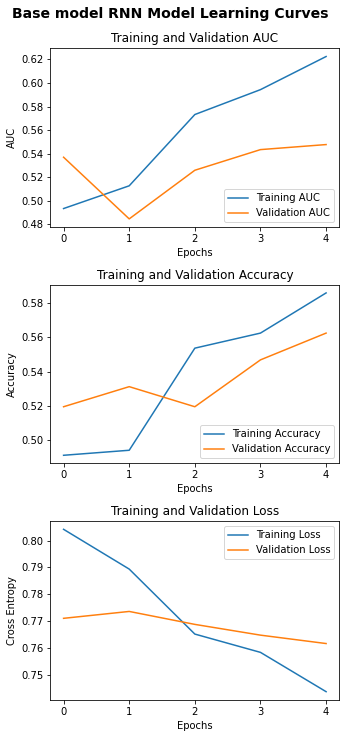

In [ ]:
# Print history keys if necessary
# base_history.history.keys()

# Give a title
title = 'Base model RNN Model Learning Curves'

# Set variables
# auc
base_auc = base_history.history['auc']
base_val_auc = base_history.history['val_auc']

# accuracy
base_acc = base_history.history['acc']
base_val_acc = base_history.history['val_acc']

# loss
base_loss = base_history.history['loss']
base_val_loss = base_history.history['val_loss']

# Call function to plot learning curves
std_learning_curves(base_history, title,
                    NUM_EPOCHS, 
                    base_auc, base_val_auc,
                    base_acc, base_val_acc,
                    base_loss, base_val_loss)

## <font color=green>2.4 - Evaluate, predict and save results</font>

In [ ]:
# Evaluate the model with Test set
start = time()
results = base_model.evaluate(X_test_pad, y_test, batch_size=BATCH_SIZE)
eval_time = (time()-start)

4/4 [==============================] - 0s 5ms/step - loss: 0.7762 - acc: 0.4844 - auc: 0.5708 - fp: 161.0000


In [ ]:
# Predict and get class (0 if pred < 0.5 else 1)
start = time()
y_pred = (base_model.predict(X_test_pad).ravel() > 0.5) + 0
pred_time = (time()-start)

In [ ]:
# Create a list to store scores/results
scores_model = []

# Append scores/results
scores_model.append({'Model': 'Simple RNN',
                     'False positives':'{:0.0f}'.format(results[3]),
                     'AUC_Score':'{:0.3f}%'.format(results[2]*100),
                     'Accuracy':'{:0.3f}%'.format(results[1]*100),
                     'Loss':'{:0.3f}%'.format(results[0]*100),
                     'Fit_time':'{:0.1f}'.format(fit_time),
                     'Eval_time':'{:0.1f}'.format(eval_time),
                     'Predict_time':'{:0.1f}'.format(pred_time)})

# Save in DF
model_results = pd.DataFrame.from_records(scores_model)
model_results

,Model,False positives,AUC_Score,Accuracy,Loss,Fit_time,Eval_time,Predict_time
0,Simple RNN,161,57.082%,48.438%,77.619%,4.1,0.1,0.2


In [ ]:
# Save to CSV file
model_results.to_csv(src_folder / 'p7_04_model_results_lm.csv', index=False)

## <font color=green>2.5 - Plot confusion matrix</font>

              precision    recall  f1-score   support

           0       0.71      0.06      0.11       171
           1       0.47      0.97      0.64       149

    accuracy                           0.48       320
   macro avg       0.59      0.52      0.37       320
weighted avg       0.60      0.48      0.35       320



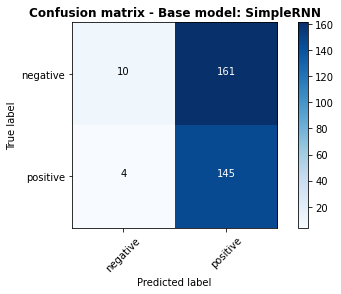

In [ ]:
# Create confusion matrix, classification report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

classes = ['negative', 'positive']
title = 'Confusion matrix - Base model: SimpleRNN'

# Call function to plot confusion matrix
plot_confusion_matrix(cm, classes, title)

print(cr)

# <font color=salmon>PART 3 - MODEL2: **LSTM and Embeddings**</font>

> **What are LSTMs?**

**Long short Term Memory (LSTM)** networks are another kind of RNNs that have the property of selectively remembering patterns for long durations of time, which makes them able to capture long term dependencies that is present in sentences.

## <font color=green>3.1 - Create the model structure</font>

In [ ]:
# Add sequential model
lstm_model = Sequential(name='lstm_model')
lstm_model.add(Embedding(input_dim=VOCAB_SIZE,
                         output_dim=EMBEDDING_DIM,
                         input_length=MAX_LEN))
lstm_model.add(SpatialDropout1D(DROP_OUT))
lstm_model.add(LSTM(128, dropout=DROP_OUT))
lstm_model.add(Dropout(DROP_OUT))
lstm_model.add(Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(REGUL_LR)))
lstm_model.add(Dropout(DROP_OUT))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 19, 256)           1280000   
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 19, 256)          0         
 lDropout1D)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_47 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dropout_48 (Dropout)        (None, 64)                0         
                                                        

## <font color=green>3.2 - Compile and fit</font>

In [ ]:
# Compile the model
lstm_model.compile(loss='binary_crossentropy',
                   optimizer=Adam(lr=OPTIM_LR),
                   metrics=METRICS)

# Fit the model
start = time()
lstm_history = lstm_model.fit(X_train_emb, y_train_emb,
                              epochs=NUM_EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(X_valid_emb, y_valid_emb),
                              callbacks=[tensorboard_callback])
fit_time = (time()-start)

# Save the model
lstm_model.save(model_folder/'lstm_model_lm.h5')

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - 3s 82ms/step - loss: 0.7739 - acc: 0.5127 - auc: 0.5062 - fp: 552.0000 - val_loss: 0.7658 - val_acc: 0.5430 - val_auc: 0.5785 - val_fp: 117.0000
Epoch 2/5
11/11 [==============================] - 0s 23ms/step - loss: 0.7622 - acc: 0.5312 - auc: 0.5688 - fp: 424.0000 - val_loss: 0.7551 - val_acc: 0.5430 - val_auc: 0.6028 - val_fp: 117.0000
Epoch 3/5
11/11 [==============================] - 0s 24ms/step - loss: 0.7512 - acc: 0.5625 - auc: 0.5884 - fp: 355.0000 - val_loss: 0.7469 - val_acc: 0.6055 - val_auc: 0.6318 - val_fp: 75.0000
Epoch 4/5
11/11 [==============================] - 0s 24ms/step - loss: 0.7360 - acc: 0.6133 - auc: 0.6775 - fp: 311.0000 - val_loss: 0.7327 - val_acc: 0.6133 - val_auc: 0.6538 - val_fp: 77.0000
Epoch 5/5
11/11 [==============================] - 0s 24ms/step - loss: 0.7100 - acc: 0.6875 - auc: 0.7485 - fp: 256.0000 - val_loss: 0.7086 - val_acc: 0.6211 - val_auc: 0.6743 - val_fp: 66.0000


## <font color=green>3.3 - Plot learning curves</font>

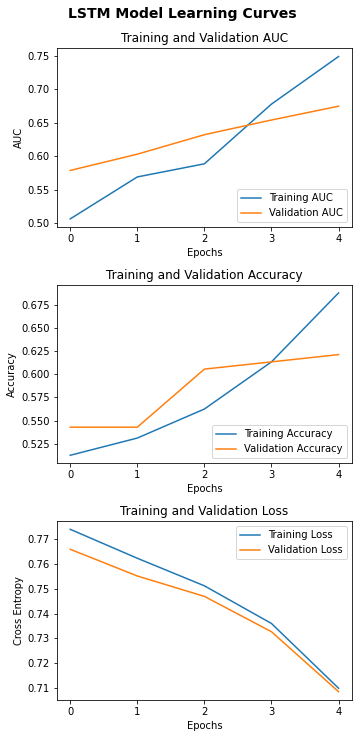

In [ ]:
# Give a title
title = 'LSTM Model Learning Curves'

# Set variables
# auc
lstm_auc = lstm_history.history['auc']
lstm_val_auc = lstm_history.history['val_auc']

# accuracy
lstm_acc = lstm_history.history['acc']
lstm_val_acc = lstm_history.history['val_acc']

# loss
lstm_loss = lstm_history.history['loss']
lstm_val_loss = lstm_history.history['val_loss']

# Call function to plot learning curves
std_learning_curves(lstm_history, title,
                    NUM_EPOCHS, 
                    lstm_auc, lstm_val_auc,
                    lstm_acc, lstm_val_acc,
                    lstm_loss, lstm_val_loss)

## <font color=green>3.4 - Evaluate, predict and save results</font>

In [ ]:
# Evaluate the model with Test set
start = time()
results = lstm_model.evaluate(X_test_pad, y_test, batch_size=BATCH_SIZE)
eval_time = (time()-start)

4/4 [==============================] - 0s 4ms/step - loss: 0.7093 - acc: 0.5906 - auc: 0.7176 - fp: 108.0000


In [ ]:
# Predict and get class (0 if pred < 0.5 else 1)
start = time()
y_pred = (lstm_model.predict(X_test_pad).ravel() > 0.5) + 0
pred_time = (time()-start)

In [ ]:
# Append to results DF
model_results = model_results.append({'Model': 'LSTM',
                                      'False positives':'{:0.0f}'.format(results[3]),
                                      'AUC_Score':'{:0.3f}%'.format(results[2]*100),
                                      'Accuracy':'{:0.3f}%'.format(results[1]*100),
                                      'Loss':'{:0.3f}%'.format(results[0]*100),
                                      'Fit_time':'{:0.1f}'.format(fit_time),
                                      'Eval_time':'{:0.1f}'.format(eval_time),
                                      'Predict_time':'{:0.1f}'.format(pred_time)},
                                     ignore_index=True)
model_results

,Model,False positives,AUC_Score,Accuracy,Loss,Fit_time,Eval_time,Predict_time
0,Simple RNN,161,57.082%,48.438%,77.619%,4.1,0.1,0.2
1,LSTM,108,71.757%,59.062%,70.933%,3.9,0.1,0.4


In [ ]:
# Save to CSV file
model_results.to_csv(src_folder / 'p7_04_model_results_lm.csv', index=False)

## <font color=green>3.5 - Plot confusion matrix</font>

              precision    recall  f1-score   support

           0       0.73      0.37      0.49       171
           1       0.54      0.85      0.66       149

    accuracy                           0.59       320
   macro avg       0.64      0.61      0.57       320
weighted avg       0.64      0.59      0.57       320



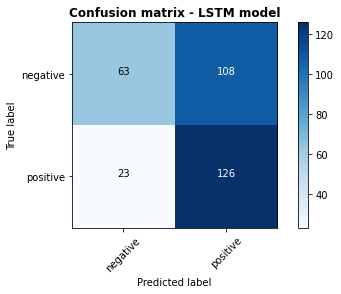

In [ ]:
# Create confusion matrix, classification report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

classes = ['negative', 'positive']
title = 'Confusion matrix - LSTM model'

# Call function to plot confusion matrix
plot_confusion_matrix(cm, classes, title)

print(cr)

# <font color=salmon>PART 4 - MODEL3: **Bidirectional LSTM and Embedding**</font>

## <font color=green>4.1 - Create the model structure</font>

In [ ]:
# Add sequential model
lstmBi_model = Sequential(name='lstmBi_model')
lstmBi_model.add(Embedding(input_dim=VOCAB_SIZE,
                           output_dim=EMBEDDING_DIM,
                           input_length=MAX_LEN))
lstmBi_model.add(SpatialDropout1D(DROP_OUT))
lstmBi_model.add(Bidirectional(LSTM(128, dropout=DROP_OUT)))
lstmBi_model.add(Dropout(DROP_OUT))
lstmBi_model.add(Dense(64, activation='relu',
                       kernel_regularizer=regularizers.l2(REGUL_LR)))
lstmBi_model.add(Dropout(DROP_OUT))
lstmBi_model.add(Dense(1, activation='sigmoid'))
lstmBi_model.summary()

Model: "lstmBi_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 19, 256)           1280000   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 19, 256)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 64)                16448     
                                                                 
 dropout_50 (Dropout)        (None, 64)               

## <font color=green>4.2 - Compile and fit</font>

In [ ]:
# Compile the model
lstmBi_model.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=OPTIM_LR),
                     metrics=METRICS)

# Fit the model
start = time()
lstmBi_history = lstmBi_model.fit(X_train_emb, y_train_emb,
                                  epochs=NUM_EPOCHS,
                                  batch_size=BATCH_SIZE,
                                  validation_data=(X_valid_emb, y_valid_emb),
                                  callbacks=[tensorboard_callback])
fit_time = (time()-start)

# Save the model
lstmBi_model.save(model_folder/'lstmBi_model_lm.h5')

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - 4s 116ms/step - loss: 0.7930 - acc: 0.4951 - auc: 0.5061 - fp: 539.0000 - val_loss: 0.7867 - val_acc: 0.4688 - val_auc: 0.5784 - val_fp: 0.0000e+00
Epoch 2/5
11/11 [==============================] - 0s 26ms/step - loss: 0.7810 - acc: 0.5166 - auc: 0.5300 - fp: 68.0000 - val_loss: 0.7728 - val_acc: 0.4883 - val_auc: 0.6080 - val_fp: 2.0000
Epoch 3/5
11/11 [==============================] - 0s 27ms/step - loss: 0.7646 - acc: 0.5547 - auc: 0.5797 - fp: 306.0000 - val_loss: 0.7568 - val_acc: 0.5391 - val_auc: 0.6196 - val_fp: 117.0000
Epoch 4/5
11/11 [==============================] - 0s 28ms/step - loss: 0.7484 - acc: 0.5879 - auc: 0.6277 - fp: 234.0000 - val_loss: 0.7454 - val_acc: 0.6328 - val_auc: 0.6778 - val_fp: 33.0000
Epoch 5/5
11/11 [==============================] - 0s 30ms/step - loss: 0.7149 - acc: 0.6699 - auc: 0.7303 - fp: 226.0000 - val_loss: 0.7282 - val_acc: 0.5742 - val_auc: 0.7055 - val_fp: 13.0000


## <font color=green>4.3 - Plot learning curves</font>

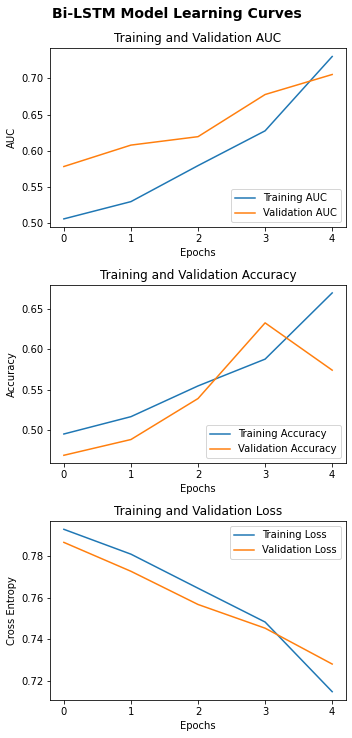

In [ ]:
# Give a title
title = 'Bi-LSTM Model Learning Curves'

# Set variables
# auc
lstmBi_auc = lstmBi_history.history['auc']
lstmBi_val_auc = lstmBi_history.history['val_auc']

# accuracy
lstmBi_acc = lstmBi_history.history['acc']
lstmBi_val_acc = lstmBi_history.history['val_acc']

# loss
lstmBi_loss = lstmBi_history.history['loss']
lstmBi_val_loss = lstmBi_history.history['val_loss']

# Call function to plot learning curves
std_learning_curves(lstmBi_history, title,
                    NUM_EPOCHS, 
                    lstmBi_auc, lstmBi_val_auc,
                    lstmBi_acc, lstmBi_val_acc,
                    lstmBi_loss, lstmBi_val_loss)

## <font color=green>4.4 - Evaluate, predict and save results</font>

In [ ]:
# Evaluate the model with Test set
start = time()
results = lstmBi_model.evaluate(X_test_pad, y_test, batch_size=BATCH_SIZE)
eval_time = (time()-start)

4/4 [==============================] - 0s 5ms/step - loss: 0.6960 - acc: 0.6625 - auc: 0.7624 - fp: 17.0000


In [ ]:
# Predict and get class (0 if pred < 0.5 else 1)
start = time()
y_pred = (lstmBi_model.predict(X_test_pad).ravel() > 0.5) + 0
pred_time = (time()-start)

In [ ]:
# Append to results DF
model_results = model_results.append({'Model': 'Bi-LSTM',
                                      'False positives':'{:0.0f}'.format(results[3]),
                                      'AUC_Score':'{:0.3f}%'.format(results[2]*100),
                                      'Accuracy':'{:0.3f}%'.format(results[1]*100),
                                      'Loss':'{:0.3f}%'.format(results[0]*100),
                                      'Fit_time':'{:0.1f}'.format(fit_time),
                                      'Eval_time':'{:0.1f}'.format(eval_time),
                                      'Predict_time':'{:0.1f}'.format(pred_time)},
                                     ignore_index=True)
model_results

,Model,False positives,AUC_Score,Accuracy,Loss,Fit_time,Eval_time,Predict_time
0,Simple RNN,161,57.082%,48.438%,77.619%,4.1,0.1,0.2
1,LSTM,108,71.757%,59.062%,70.933%,3.9,0.1,0.4
2,Bi-LSTM,17,76.235%,66.250%,69.596%,5.6,0.1,0.7


In [ ]:
# Save to CSV file
model_results.to_csv(src_folder / 'p7_04_model_results_lm.csv', index=False)

## <font color=green>4.5 - Plot confusion matrix</font>

              precision    recall  f1-score   support

           0       0.63      0.90      0.74       171
           1       0.77      0.39      0.52       149

    accuracy                           0.66       320
   macro avg       0.70      0.64      0.63       320
weighted avg       0.70      0.66      0.64       320



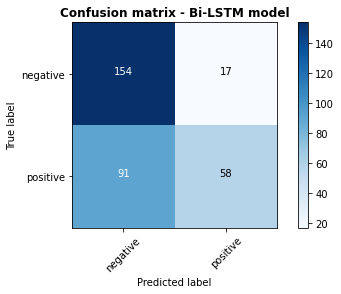

In [ ]:
# Create confusion matrix, classification report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

classes = ['negative', 'positive']
title = 'Confusion matrix - Bi-LSTM model'

# Call function to plot confusion matrix
plot_confusion_matrix(cm, classes, title)

print(cr)

# <font color=salmon>PART 5 - MODEL4: **Word2Vec pre-trained embeddings**</font>

**Word2vec** is a group of related models that are used to produce word embeddings. 

The idea behind Word2Vec is analogous to say: "show me your friends, and I'll tell you who you are" because the main assumption is that *the meaning of a word can be inferred by its neighbors*.

**If we have 2 words that have very similar neighbors, then these words are probably quite simila in meaning or are at least related.**

More technical information can be found on [Wikipedia](https://en.wikipedia.org/wiki/Word2vec).

The pre-trained model (word and phrase vectors) can be downloaded [here](https://code.google.com/archive/p/word2vec/). It was trained on about 100 billion words of Google News Dataset. It contains 300-dimensional vectors for 3 million words and phrases.

## <font color=green>5.1 - Load Word2Vec embeddings</font>

In [ ]:
from gensim.models import KeyedVectors

# Load vectors directly from the file
w2v_embeddings = KeyedVectors.load_word2vec_format(src_folder / 'GoogleNews-vectors-negative300.bin',
                                                   binary=True, limit=100000)

In [ ]:
from tqdm import tqdm

# Vector dimension for w2v embedding 
W2V_DIM = 300

# Create embedding matrix for word in train set
embeddings_matrix = np.zeros((len(word_index) + 1, W2V_DIM))
hits = 0
misses = 0

for word, i in tqdm(word_index.items()):
    # Check if the word occurs in w2v embedding
    if word in w2v_embeddings.vocab:
        # If not, keep the vector with zeros only
        embeddings_matrix[i] = w2v_embeddings[word]
        hits += 1
    else:
        misses += 1

print('\n')
print('Wordindex length: ', len(word_index)+1)
print('Converted words: {}, missing words: {}'.format(hits, misses))
print('% of missing words: {:.1f}%'.format(misses/(hits+misses)*100))

100%|██████████| 3194/3194 [00:00<00:00, 320684.79it/s]



Wordindex length:  3195
Converted words: 2228, missing words: 966
% of missing words: 30.2%


## <font color=green>5.2 - Create the model structure</font>

We are now ready to specify the Keras layers.

In [ ]:
# Add sequential model
w2v_model = Sequential(name='word2vec_model')
w2v_model.add(Embedding(input_dim=len(word_index) + 1,
                          output_dim=W2V_DIM,
                          weights=[embeddings_matrix],
                          input_length=MAX_LEN,
                          trainable=False))
w2v_model.add(SpatialDropout1D(DROP_OUT))
w2v_model.add(LSTM(128)) #, dropout=DROP_OUT
w2v_model.add(Dropout(DROP_OUT))
w2v_model.add(Dense(64, activation='relu',
                      kernel_regularizer=regularizers.l2(REGUL_LR)))
w2v_model.add(Dropout(DROP_OUT))
w2v_model.add(Dense(1, activation='sigmoid'))
w2v_model.summary()

Model: "word2vec_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 19, 300)           958500    
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 19, 300)          0         
 lDropout1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 128)               219648    
                                                                 
 dropout_51 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout_52 (Dropout)        (None, 64)                0         
                                                    

## <font color=green>5.3 - Compile and fit</font>

In [ ]:
# Compile the model
w2v_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=OPTIM_LR),
                  metrics=METRICS)

# Fit the model
start = time()
w2v_history = w2v_model.fit(X_train_emb, y_train_emb,
                            epochs=NUM_EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_valid_emb, y_valid_emb),
                            callbacks=[tensorboard_callback])
fit_time = (time()-start)

# Save the model
w2v_model.save(model_folder/'w2v_model_lm.h5')

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - 4s 82ms/step - loss: 0.7735 - acc: 0.5352 - auc: 0.5426 - fp: 212.0000 - val_loss: 0.7650 - val_acc: 0.5742 - val_auc: 0.6142 - val_fp: 24.0000
Epoch 2/5
11/11 [==============================] - 0s 21ms/step - loss: 0.7524 - acc: 0.6152 - auc: 0.6397 - fp: 176.0000 - val_loss: 0.7468 - val_acc: 0.6016 - val_auc: 0.6429 - val_fp: 40.0000
Epoch 3/5
11/11 [==============================] - 0s 21ms/step - loss: 0.7276 - acc: 0.6562 - auc: 0.6876 - fp: 162.0000 - val_loss: 0.7199 - val_acc: 0.6250 - val_auc: 0.6737 - val_fp: 55.0000
Epoch 4/5
11/11 [==============================] - 0s 22ms/step - loss: 0.6835 - acc: 0.6748 - auc: 0.7375 - fp: 217.0000 - val_loss: 0.7098 - val_acc: 0.5977 - val_auc: 0.6884 - val_fp: 44.0000
Epoch 5/5
11/11 [==============================] - 0s 22ms/step - loss: 0.6686 - acc: 0.6836 - auc: 0.7416 - fp: 157.0000 - val_loss: 0.6964 - val_acc: 0.6523 - val_auc: 0.7177 - val_fp: 70.0000


## <font color=green>5.4 - Plot learning curves</font>

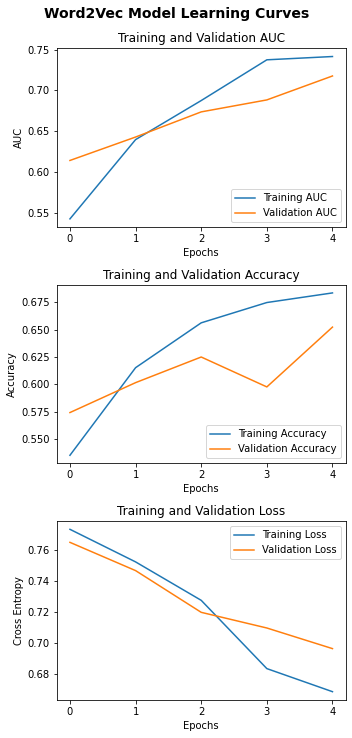

In [ ]:
# Give a title
title = 'Word2Vec Model Learning Curves'

# Set variables
# auc
w2v_auc = w2v_history.history['auc']
w2v_val_auc = w2v_history.history['val_auc']

# accuracy
w2v_acc = w2v_history.history['acc']
w2v_val_acc = w2v_history.history['val_acc']

# loss
w2v_loss = w2v_history.history['loss']
w2v_val_loss = w2v_history.history['val_loss']

# Call function to plot learning curves
std_learning_curves(w2v_history, title,
                    NUM_EPOCHS, 
                    w2v_auc, w2v_val_auc,
                    w2v_acc, w2v_val_acc,
                    w2v_loss, w2v_val_loss)

## <font color=green>5.5 - Evaluate, predict and save results</font>

In [ ]:
# Evaluate the model with Test set
start = time()
results = w2v_model.evaluate(X_test_pad, y_test, batch_size=BATCH_SIZE)
eval_time = (time()-start)

4/4 [==============================] - 0s 4ms/step - loss: 0.7101 - acc: 0.6187 - auc: 0.7346 - fp: 105.0000


In [ ]:
# Append to results DF
model_results = model_results.append({'Model': 'Word2Vec +LSTM',
                                      'False positives':'{:0.0f}'.format(results[3]),
                                      'AUC_Score':'{:0.3f}%'.format(results[2]*100),
                                      'Accuracy':'{:0.3f}%'.format(results[1]*100),
                                      'Loss':'{:0.3f}%'.format(results[0]*100),
                                      'Fit_time':'{:0.1f}'.format(fit_time),
                                      'Eval_time':'{:0.1f}'.format(eval_time),
                                      'Predict_time':'{:0.1f}'.format(pred_time)},
                                     ignore_index=True)
model_results

,Model,False positives,AUC_Score,Accuracy,Loss,Fit_time,Eval_time,Predict_time
0,Simple RNN,161,57.082%,48.438%,77.619%,4.1,0.1,0.2
1,LSTM,108,71.757%,59.062%,70.933%,3.9,0.1,0.4
2,Bi-LSTM,17,76.235%,66.250%,69.596%,5.6,0.1,0.7
3,Word2Vec +LSTM,105,73.460%,61.875%,71.015%,4.7,0.1,0.7


In [ ]:
# Predict and get class (0 if pred < 0.5 else 1)
start = time()
y_pred = (w2v_model.predict(X_test_pad).ravel() > 0.5) + 0
pred_time = (time()-start)

In [ ]:
# Save to CSV file
model_results.to_csv(src_folder / 'p7_04_model_results_lm.csv', index=False)

## <font color=green>5.6 - Plot confusion matrix</font>

              precision    recall  f1-score   support

           0       0.80      0.39      0.52       171
           1       0.56      0.89      0.68       149

    accuracy                           0.62       320
   macro avg       0.68      0.64      0.60       320
weighted avg       0.68      0.62      0.60       320



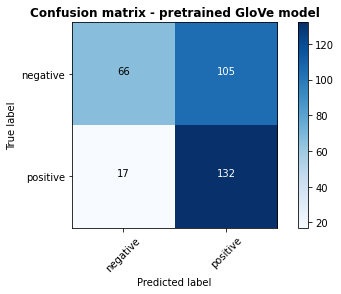

In [ ]:
# Create confusion matrix, classification report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

classes = ['negative', 'positive']
title = 'Confusion matrix - pretrained GloVe model'

# Call function to plot confusion matrix
plot_confusion_matrix(cm, classes, title)

print(cr)

# <font color=salmon>PART 6 - MODEL5: **GloVe pre-trained embeddings**</font>

**GloVe (*Global Vectors for Word Representation*)** aims to capture the relationship between the words of the entire corpus: it trains a model based on global co-occurence counts of words, global statistics and uses **mean squared error** as the loss function.

The generated word embedding with such a model preserves word relationships and similarities.

More information on [Stanford NLP Group - Edu](https://nlp.stanford.edu/projects/glove/).

## <font color=green>6.1 - Load GloVe embeddings (Twitter version - 200D)</font>

In [ ]:
# from IPython.display import clear_output

# # Download and extract GloVe file
# # https://nlp.stanford.edu/projects/glove/
# # http://nlp.stanford.edu/data/glove.6B.zip

# # Use web get command
# !wget -P '/content/drive/MyDrive/OC_IA/P07' http://nlp.stanford.edu/data/glove.twitter.27B.zip

# # Unzip in the same directory
# !unzip '/content/drive/MyDrive/OC_IA/P07/glove.twitter.27B.zip' -d '/content/drive/MyDrive/OC_IA/P07'

# # Remove zip file
# !rm '/content/drive/MyDrive/OC_IA/P07/glove.twitter.27B.zip'

# clear_output()

The download has provided 4 files, respectively: 25d, 50d, 100d and 200d vector dimensions.

We choose 200D vector dimensions for "almost comparable" vector dimension against the other models.

In [ ]:
# The download provides 4 files: 25d, 50d, 100d and 200d
# Define path variable
glove_path = src_folder / 'glove.twitter.27B.200d.txt'

# Look at first line in the file
with open(glove_path, 'r', encoding='utf-8') as f:
    line = f.readline()
line

'<user> 0.31553 0.53765 0.10177 0.032553 0.003798 0.015364 -0.20344 0.33294 -0.20886 0.10061 0.30976 0.50015 0.32018 0.13537 0.0087039 0.1911 0.24668 -0.060752 -0.43623 0.019302 0.59972 0.13444 0.012801 -0.54052 0.27387 -1.182 -0.27677 0.11279 0.46596 -0.090685 0.24253 0.15654 -0.23618 0.57694 0.17563 -0.01969 0.018295 0.37569 -0.41984 0.22613 -0.20438 -0.076249 0.40356 0.61582 -0.10064 0.23318 0.22808 0.34576 -0.14627 -0.1988 0.033232 -0.84885 -0.25684 0.26369 0.29562 0.1847 -0.20668 -0.013297 0.12233 -0.47751 -0.17202 -0.14577 0.047446 -0.15824 0.054215 -0.19426 -0.081484 0.099009 0.10159 0.043571 0.50245 0.13362 0.065985 0.032969 -0.2017 -0.56905 -0.13203 0.073347 -0.063728 -0.2796 -0.38481 -0.020193 0.22298 -0.059115 0.045198 -0.13995 -0.13299 0.47309 -0.021874 0.38758 -0.074926 -0.0028093 -0.29829 -0.074987 -0.58542 -0.18065 -0.041805 0.41938 0.41004 -0.5911 0.10459 0.10724 0.69768 -0.15901 -0.059596 0.29368 -0.19609 0.39124 -0.29333 -0.0050833 -0.37854 0.33858 0.24782 0.29144 -0.

We use the downloaded GloVe embeddings to create an embedding matrix, where the rows contain the word embeddings for the tokens in the Tokenizer's vocabulary.

In [ ]:
# Load GloVe vectors in a dictionary
embeddings_index = {}

glove = open(glove_path, 'r', encoding='utf-8')
for line in glove:
    values = line.split(' ')
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = vector
glove.close()

# Display GloVe embedding length
print('# Word vectors found: {}'.format(len(embeddings_index)))

# Word vectors found: 1193514


In [ ]:
# https://keras.io/examples/nlp/pretrained_word_embeddings/
from tqdm import tqdm

# Number of dimension of GloVe word embedding 
GLOVE_DIM = 200

# Create embedding matrix for word in train set
embeddings_matrix = np.zeros((len(word_index) + 1, GLOVE_DIM))
hits = 0
misses = 0

for word, i in tqdm(word_index.items()):
    # Check if the word occurs in Glove embedding
    embeddings_vector = embeddings_index.get(word)
    if embeddings_vector is not None:
        # If not, keep the vector with zeros only
        embeddings_matrix[i] = embeddings_vector
        hits += 1
    else:
        misses += 1

print('\n')
print('Wordindex length: ', len(word_index)+1)
print('Converted words: {}, missing words: {}'.format(hits, misses))
print('% of missing words: {:.1f}%'.format(misses/(hits+misses)*100))

100%|██████████| 3194/3194 [00:00<00:00, 384617.35it/s]



Wordindex length:  3195
Converted words: 3085, missing words: 109
% of missing words: 3.4%


## <font color=green>6.2 - Create the model structure</font>

We are now ready to specify the Keras layers.

In [ ]:
# Add sequential model
glove_model = Sequential(name='glove_model')
glove_model.add(Embedding(input_dim=len(word_index) + 1,
                          output_dim=GLOVE_DIM,
                          weights=[embeddings_matrix],
                          input_length=MAX_LEN,
                          trainable=False))
# gloveT_model.add(SpatialDropout1D(DROP_OUT))
glove_model.add(LSTM(128)) #, dropout=DROP_OUT
# gloveT_model.add(Dropout(DROP_OUT))
glove_model.add(Dense(64, activation='relu',
                      kernel_regularizer=regularizers.l2(REGUL_LR)))
# gloveT_model.add(Dropout(DROP_OUT))
glove_model.add(Dense(1, activation='sigmoid'))
glove_model.summary()

Model: "glove_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 19, 200)           639000    
                                                                 
 lstm_8 (LSTM)               (None, 128)               168448    
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 815,769
Trainable params: 176,769
Non-trainable params: 639,000
_________________________________________________________________


## <font color=green>6.3 - Compile and fit</font>

In [ ]:
# Compile the model
glove_model.compile(loss='binary_crossentropy',
                    optimizer=Adam(lr=OPTIM_LR),
                    metrics=METRICS)

# Fit the model
start = time()
glove_history = glove_model.fit(X_train_emb, y_train_emb,
                                epochs=NUM_EPOCHS,
                                batch_size=BATCH_SIZE,
                                validation_data=(X_valid_emb, y_valid_emb),
                                callbacks=[tensorboard_callback])
fit_time = (time()-start)

# Save the model
glove_model.save(model_folder/'glove_model_lm.h5')

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - 3s 80ms/step - loss: 0.7438 - acc: 0.5830 - auc: 0.6523 - fp: 364.0000 - val_loss: 0.7449 - val_acc: 0.6328 - val_auc: 0.6698 - val_fp: 18.0000
Epoch 2/5
11/11 [==============================] - 0s 17ms/step - loss: 0.6560 - acc: 0.6904 - auc: 0.7781 - fp: 169.0000 - val_loss: 0.7218 - val_acc: 0.6562 - val_auc: 0.7007 - val_fp: 34.0000
Epoch 3/5
11/11 [==============================] - 0s 18ms/step - loss: 0.5954 - acc: 0.7314 - auc: 0.8171 - fp: 144.0000 - val_loss: 0.7155 - val_acc: 0.6680 - val_auc: 0.7189 - val_fp: 34.0000
Epoch 4/5
11/11 [==============================] - 0s 18ms/step - loss: 0.5377 - acc: 0.7812 - auc: 0.8641 - fp: 104.0000 - val_loss: 0.7032 - val_acc: 0.6562 - val_auc: 0.7180 - val_fp: 47.0000
Epoch 5/5
11/11 [==============================] - 0s 17ms/step - loss: 0.4888 - acc: 0.8154 - auc: 0.8900 - fp: 93.0000 - val_loss: 0.7166 - val_acc: 0.6680 - val_auc: 0.7332 - val_fp: 41.0000


## <font color=green>6.4 - Plot learning curves</font>

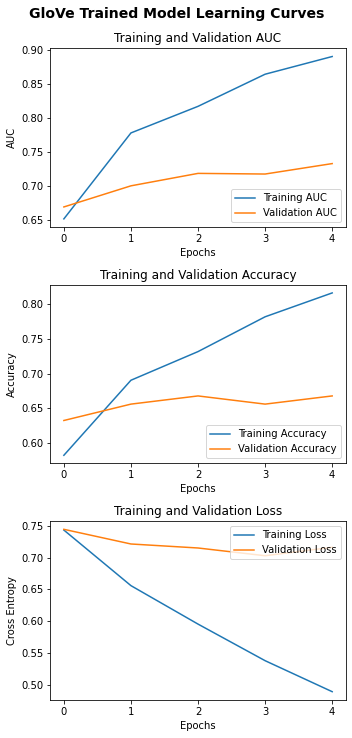

In [ ]:
# Give a title
title = 'GloVe Trained Model Learning Curves'

# Set variables
# auc
glove_auc = glove_history.history['auc']
glove_val_auc = glove_history.history['val_auc']

# accuracy
glove_acc = glove_history.history['acc']
glove_val_acc = glove_history.history['val_acc']

# loss
glove_loss = glove_history.history['loss']
glove_val_loss = glove_history.history['val_loss']

# Call function to plot learning curves
std_learning_curves(glove_history, title,
                    NUM_EPOCHS, 
                    glove_auc, glove_val_auc,
                    glove_acc, glove_val_acc,
                    glove_loss, glove_val_loss)

## <font color=green>6.5 - Evaluate, predict and save results</font>

In [ ]:
# Evaluate the model with Test set
start = time()
results = glove_model.evaluate(X_test_pad, y_test, batch_size=BATCH_SIZE)
eval_time = (time()-start)

4/4 [==============================] - 0s 4ms/step - loss: 0.6549 - acc: 0.7281 - auc: 0.7788 - fp: 46.0000


In [ ]:
# Predict and get class (0 if pred < 0.5 else 1)
start = time()
y_pred = (glove_model.predict(X_test_pad).ravel() > 0.5) + 0
pred_time = (time()-start)

In [ ]:
# Append to results DF
model_results = model_results.append({'Model': 'GloVe +LSTM',
                                      'False positives':'{:0.0f}'.format(results[3]),
                                      'AUC_Score':'{:0.3f}%'.format(results[2]*100),
                                      'Accuracy':'{:0.3f}%'.format(results[1]*100),
                                      'Loss':'{:0.3f}%'.format(results[0]*100),
                                      'Fit_time':'{:0.1f}'.format(fit_time),
                                      'Eval_time':'{:0.1f}'.format(eval_time),
                                      'Predict_time':'{:0.1f}'.format(pred_time)},
                                     ignore_index=True)
model_results

,Model,False positives,AUC_Score,Accuracy,Loss,Fit_time,Eval_time,Predict_time
0,Simple RNN,161,57.082%,48.438%,77.619%,4.1,0.1,0.2
1,LSTM,108,71.757%,59.062%,70.933%,3.9,0.1,0.4
2,Bi-LSTM,17,76.235%,66.250%,69.596%,5.6,0.1,0.7
3,Word2Vec +LSTM,105,73.460%,61.875%,71.015%,4.7,0.1,0.7
4,GloVe +LSTM,46,77.884%,72.812%,65.494%,3.5,0.1,0.4


In [ ]:
# Save to CSV file
model_results.to_csv(src_folder / 'p7_04_model_results_lm.csv', index=False)

## <font color=green>6.6 - Plot confusion matrix</font>

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       171
           1       0.70      0.72      0.71       149

    accuracy                           0.73       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.73      0.73      0.73       320



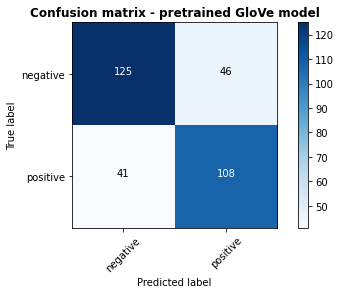

In [ ]:
# Create confusion matrix, classification report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

classes = ['negative', 'positive']
title = 'Confusion matrix - pretrained GloVe model'

# Call function to plot confusion matrix
plot_confusion_matrix(cm, classes, title)

print(cr)

# <font color=salmon>PART 7 - MODEL6: **BERT pre-trained embeddings**</font>

## <font color=green>7.1 - import BERT model and get embeding vectors</font>

### Install Huggingface Transformers

In [ ]:
!pip install -qq transformers

In [ ]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertModel

from tqdm import tqdm

### Train / Validation split

In [ ]:
sentiments = sample_df.sentiment.values.tolist()
tweets = sample_df.text.values.tolist()

from sklearn.model_selection import train_test_split
training_sentences, test_sentences, training_labels, test_labels = train_test_split(tweets, sentiments, test_size=.2)
training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(training_sentences, training_labels, test_size=.2)

### Tokenization

In [ ]:
# First load the real tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

### Hyperparameters-Transformers

In [ ]:
BATCH_SIZE = 16 #* strategy.num_replicas_in_sync
EPOCHS=2
LEARNING_RATE=1e-5
early_stopping=early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
AUTO = tf.data.experimental.AUTOTUNE
max_seq_length = 19

In [ ]:
def encoding_function(text,tokenizer):
    input_ids=[]
    tokenizer.pad_token='[PAD]'
    
    for sentence in tqdm(text):
        encoded=tokenizer.encode(sentence,max_length=max_seq_length,pad_to_max_length=True)
        input_ids.append(encoded)
    return input_ids

In [ ]:
X_train=np.array(encoding_function(training_sentences,tokenizer))
y_train=np.array(training_labels)

X_valid=np.array(encoding_function(validation_sentences,tokenizer))
y_valid=np.array(validation_labels)

X_test=np.array(encoding_function(test_sentences,tokenizer))

  0%|          | 0/1024 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 320/320 [00:00<00:00, 3598.89it/s]


### TensorFlow dataset

In [ ]:
def make_data():
    train = (
        tf.data.Dataset
        .from_tensor_slices((X_train, y_train))
        .repeat()
        .shuffle(2048)
        .batch(BATCH_SIZE)
        .prefetch(AUTO))

    valid = (
        tf.data.Dataset
        .from_tensor_slices((X_valid, y_valid))
        .batch(BATCH_SIZE)
        .cache()
        .prefetch(AUTO)
    )

    test = (
        tf.data.Dataset
        .from_tensor_slices(X_test)
        .batch(BATCH_SIZE)
    )
    return train, valid, test

In [ ]:
train, valid, test = make_data()

## <font color=green>7.2 - Create & Complie the model</font>

In [ ]:
def build_model(transformer_layer, max_len=max_seq_length):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer_layer(input_word_ids)[0]
    
    cls_token = sequence_output[:, 0, :]
    out = tf.keras.layers.Dense(1, activation='sigmoid')(cls_token)
    
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    
    
    return model

In [ ]:
%%time
def compile_model(name):
    METRICS = [tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc')]
      
    transformer_layer = (TFDistilBertModel.from_pretrained(name))

    model = build_model(transformer_layer, max_len=max_seq_length)

    model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=METRICS)

    return model

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [ ]:
steps_per_epoch=X_train.shape[0]//BATCH_SIZE

bert_model=compile_model('bert-base-uncased')
print(bert_model.summary())



You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFDistilBertModel: ['mlm___cls', 'nsp___cls', 'bert']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['distilbert']
You should probably TRAIN this model on a down-stream task to be able to use it for pred

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 19)]             0         
                                                                 
 tf_distil_bert_model_1 (TFD  TFBaseModelOutput(last_h  108890112
 istilBertModel)             idden_state=(None, 19, 7            
                             68),                                
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem_1   (None, 768)              0         
 (SlicingOpLambda)                                               
                                                                 
 dense_23 (Dense)            (None, 1)                 769       
                                                           

## <font color=green>7.3 - fit Model</font>

In [ ]:
start = time()
bert_history=bert_model.fit(
    train, steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS, callbacks=[early_stopping], validation_data=valid
)
fit_time = (time()-start)

Epoch 1/2
64/64 [==============================] - 27s 137ms/step - loss: 0.9107 - fp: 246.0000 - accuracy: 0.5293 - auc: 0.5402 - val_loss: 0.8039 - val_fp: 0.0000e+00 - val_accuracy: 0.4492 - val_auc: 0.6819
Epoch 2/2
64/64 [==============================] - 5s 80ms/step - loss: 0.7087 - fp: 246.0000 - accuracy: 0.5293 - auc: 0.5385 - val_loss: 0.6850 - val_fp: 107.0000 - val_accuracy: 0.5703 - val_auc: 0.6434


In [ ]:
# Save the model
bert_model.save(model_folder/'bert_model_lm.h5')
# bert_model.save_pretrained(model_folder/'bert_model')

## <font color=green>7.4 - Plot learning curves</font>

In [ ]:
bert_history.history

{'accuracy': [0.529296875, 0.529296875],
 'auc': [0.5401515960693359, 0.5385342240333557],
 'fp': [246.0, 246.0],
 'loss': [0.9107245206832886, 0.708719789981842],
 'val_accuracy': [0.44921875, 0.5703125],
 'val_auc': [0.6818686723709106, 0.6433549523353577],
 'val_fp': [0.0, 107.0],
 'val_loss': [0.8038633465766907, 0.6849884390830994]}

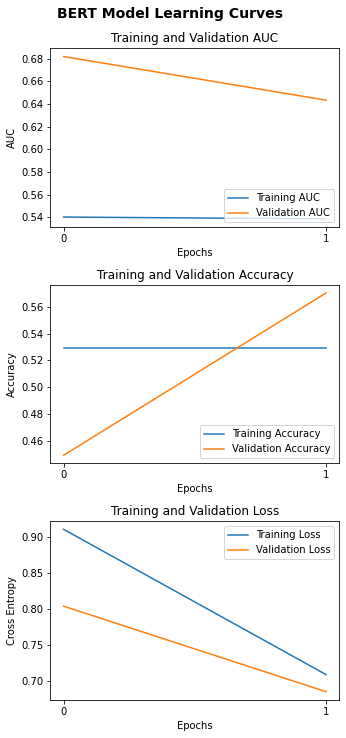

In [ ]:
# Give a title
title = 'BERT Model Learning Curves'

# Set variables
# auc
bert_auc = bert_history.history['auc']
bert_val_auc = bert_history.history['val_auc']

# accuracy
bert_acc = bert_history.history['accuracy']
bert_val_acc = bert_history.history['val_accuracy']

# loss
bert_loss = bert_history.history['loss']
bert_val_loss = bert_history.history['val_loss']

# Call function to plot learning curves
std_learning_curves(bert_history, title,
                    EPOCHS, 
                    bert_auc, bert_val_auc,
                    bert_acc, bert_val_acc,
                    bert_loss, bert_val_loss)

## <font color=green>7.5 - Evaluate, predict and save results</font>

In [ ]:
# Evaluate the model with Test set
start = time()
results = bert_model.evaluate(valid)
eval_time = (time()-start)

16/16 [==============================] - 1s 34ms/step - loss: 0.6850 - fp: 107.0000 - accuracy: 0.5703 - auc: 0.6434


In [ ]:
# Predict and get class (0 if pred < 0.5 else 1)
start = time()
y_pred=bert_model.predict(valid, verbose=1)
pred_time = (time()-start)

y_pred[ y_pred> 0.5] = 1
y_pred[y_pred <= 0.5] = 0

16/16 [==============================] - 3s 29ms/step


In [ ]:
results

[0.6849884390830994, 107.0, 0.5703125, 0.6433549523353577]

In [ ]:
# Append to results DF
model_results = model_results.append({'Model': 'BERT',
                                      'False positives':'{:0.0f}'.format(results[1]),
                                      'AUC_Score':'{:0.3f}%'.format(results[3]*100),
                                      'Accuracy':'{:0.3f}%'.format(results[2]*100),
                                      'Loss':'{:0.3f}%'.format(results[0]*100),
                                      'Fit_time':'{:0.1f}'.format(fit_time),
                                      'Eval_time':'{:0.1f}'.format(eval_time),
                                      'Predict_time':'{:0.1f}'.format(pred_time)},
                                     ignore_index=True)
model_results

,Model,False positives,AUC_Score,Accuracy,Loss,Fit_time,Eval_time,Predict_time
0,Simple RNN,161,57.082%,48.438%,77.619%,4.1,0.1,0.2
1,LSTM,108,71.757%,59.062%,70.933%,3.9,0.1,0.4
2,Bi-LSTM,17,76.235%,66.250%,69.596%,5.6,0.1,0.7
3,Word2Vec +LSTM,105,73.460%,61.875%,71.015%,4.7,0.1,0.7
4,GloVe +LSTM,46,77.884%,72.812%,65.494%,3.5,0.1,0.4
5,BERT,107,64.335%,57.031%,68.499%,31.8,0.6,2.9


In [ ]:
# Save to CSV file
model_results.to_csv(src_folder / 'p7_04_model_results_lm.csv', index=False)

## <font color=green>7.6 - Plot confusion matrix</font>

              precision    recall  f1-score   support

           0       0.73      0.07      0.13       115
           1       0.56      0.98      0.72       141

    accuracy                           0.57       256
   macro avg       0.65      0.52      0.42       256
weighted avg       0.64      0.57      0.45       256



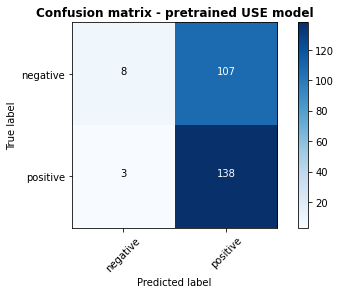

In [ ]:
# Create confusion matrix, classification report
cm = confusion_matrix(y_valid, y_pred)
cr = classification_report(y_valid, y_pred)

classes = ['negative', 'positive']
title = 'Confusion matrix - pretrained USE model'

# Call function to plot confusion matrix
plot_confusion_matrix(cm, classes, title)

print(cr)

# <font color=salmon>PART 8 - FINAL MODEL: GloVe</font>

## <font color=green>8.1 - Re-load libraries and dataframe</font>

In [ ]:
# Check the activated GPU
import tensorflow as tf
print('Tensorflow version: ',tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version:  2.7.0
Found GPU at: /device:GPU:0


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from time import time
import json
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
%matplotlib inline

# Set variables
src_folder = Path('/content/drive/MyDrive/OC_IA/P07')
model_folder = Path(src_folder / 'final_model')
VOCAB_SIZE = 50000
MAX_LEN = 36
GLOVE_DIM = 200
OPTIM_LR = 0.001
REGUL_LR = 0.001
FP = tf.keras.metrics.FalsePositives(name='fp')
METRICS = ['acc', 'AUC', FP]
NUM_EPOCHS = 5
BATCH_SIZE = 250

# Import data and keep only needed columns
data = pd.read_csv(src_folder / 'p7_01b_final_df.csv')

# df = data[['clean_tweet', 'sentiment']]
# df.rename(columns={'clean_tweet':'text'}, inplace=True)
df = data[['lemma_tweet', 'sentiment']]
df.rename(columns={'lemma_tweet':'text'}, inplace=True)
# df = data[['stem_tweet', 'sentiment']]
# df.rename(columns={'stem_tweet':'text'}, inplace=True)

# Split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.text,
                                                    df.sentiment,
                                                    test_size=0.2,
                                                    random_state=42)

# Vectorize (convert words to numbers) with Keras tokenizer
tk = Tokenizer(num_words=VOCAB_SIZE)
tk.fit_on_texts(X_train)

# Save as pickle (wb: write binary)
with open(model_folder / 'p7_04_tokenizer_lm.pickle', 'wb') as handle:
    pickle.dump(tk, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Get the dictionary of vocab created by Keras AND SAVE for later use!!
word_index = tk.word_index

# Convert texts to sequences
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

# Zero truncate or pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

# Add validation data
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_pad,
                                                                      y_train,
                                                                      test_size=0.2,
                                                                      random_state=42)

## <font color=green>8.2 - Train on total dataframe</font>

In [ ]:
# Define path variable of glove embedding (200d)
glove_path = src_folder / 'glove.twitter.27B.200d.txt'

# Load GloVe vectors in a dictionary
embeddings_index = {}

glove = open(glove_path, 'r', encoding='utf-8')
for line in glove:
    values = line.split(' ')
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = vector
glove.close()

# Create embedding matrix for word in train set
embeddings_matrix = np.zeros((len(word_index) + 1, GLOVE_DIM))

for word, i in word_index.items():
    # Check if the word occurs in Glove embedding
    embeddings_vector = embeddings_index.get(word)
    if embeddings_vector is not None:
        # If not, keep the vector with zeros only
        embeddings_matrix[i] = embeddings_vector

# Add sequential model
glove_model = Sequential(name='full_glove_model')
glove_model.add(Embedding(input_dim=len(word_index) + 1,
                          output_dim=GLOVE_DIM,
                          weights=[embeddings_matrix],
                          input_length=MAX_LEN,
                          trainable=False))
glove_model.add(LSTM(128))
glove_model.add(Dense(64, activation='relu',
                      kernel_regularizer=regularizers.l2(REGUL_LR)))
glove_model.add(Dense(1, activation='sigmoid'))

# Compile the model
glove_model.compile(loss='binary_crossentropy',
                    optimizer=Adam(learning_rate=OPTIM_LR),
                    metrics=METRICS)

In [ ]:
# Fit the model
start = time()
glove_history = glove_model.fit(X_train_emb, y_train_emb,
                                epochs=NUM_EPOCHS,
                                batch_size=BATCH_SIZE,
                                validation_data=(X_valid_emb, y_valid_emb))
fit_time = (time()-start)

# Save the model
glove_model.save(model_folder/'full_glove_model_lm.h5')

Epoch 1/5
3994/3994 [==============================] - 31s 7ms/step - loss: 0.4448 - acc: 0.7958 - auc: 0.8780 - fp: 99274.0000 - val_loss: 0.4205 - val_acc: 0.8066 - val_auc: 0.8897 - val_fp: 24296.0000
Epoch 2/5
3994/3994 [==============================] - 28s 7ms/step - loss: 0.4107 - acc: 0.8133 - auc: 0.8951 - fp: 92090.0000 - val_loss: 0.4100 - val_acc: 0.8122 - val_auc: 0.8956 - val_fp: 22091.0000
Epoch 3/5
3994/3994 [==============================] - 28s 7ms/step - loss: 0.3973 - acc: 0.8207 - auc: 0.9022 - fp: 88568.0000 - val_loss: 0.4069 - val_acc: 0.8145 - val_auc: 0.8976 - val_fp: 25451.0000
Epoch 4/5
3994/3994 [==============================] - 29s 7ms/step - loss: 0.3866 - acc: 0.8270 - auc: 0.9078 - fp: 85621.0000 - val_loss: 0.4061 - val_acc: 0.8156 - val_auc: 0.8979 - val_fp: 22789.0000
Epoch 5/5
3994/3994 [==============================] - 28s 7ms/step - loss: 0.3767 - acc: 0.8325 - auc: 0.9128 - fp: 82861.0000 - val_loss: 0.4052 - val_acc: 0.8156 - val_auc: 0.8983 -

## <font color=green>8.3 - Plot learning curves</font>

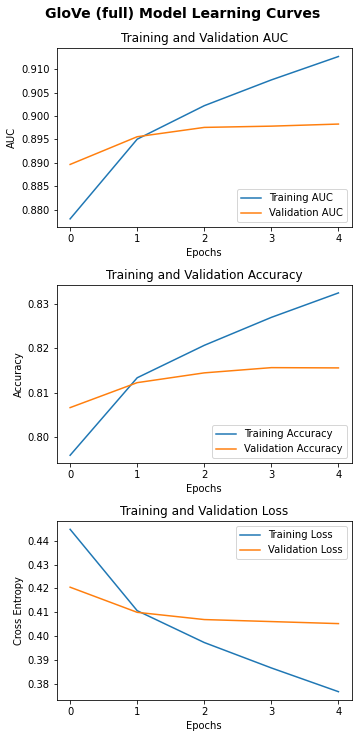

In [ ]:
# matplotlib
import matplotlib.pyplot as plt

# Give a title
title = 'GloVe (full) Model Learning Curves'

# Set variables
# auc
glove_auc = glove_history.history['auc']
glove_val_auc = glove_history.history['val_auc']

# accuracy
glove_acc = glove_history.history['acc']
glove_val_acc = glove_history.history['val_acc']

# loss
glove_loss = glove_history.history['loss']
glove_val_loss = glove_history.history['val_loss']

# Call function to plot learning curves
std_learning_curves(glove_history, title,
                    NUM_EPOCHS, 
                    glove_auc, glove_val_auc,
                    glove_acc, glove_val_acc,
                    glove_loss, glove_val_loss)

## <font color=green>8.4 - Evaluate, predict and save results</font>

In [ ]:
# Evaluate the model with Test set
start = time()
results = glove_model.evaluate(X_test_pad, y_test, batch_size=BATCH_SIZE)
eval_time = (time()-start)

1248/1248 [==============================] - 5s 4ms/step - loss: 0.4055 - acc: 0.8164 - auc: 0.8981 - fp: 29843.0000


In [ ]:
# Predict and get !!PROBABILITIES!!
start = time()
y_pred = glove_model.predict(X_test_pad)
pred_time = (time()-start)

In [ ]:
# Append to results DF
# model_results = pd.read_csv(src_folder / 'p7_04_model_results_lmean.csv')
model_results = model_results.append({'Model': 'Glove (full DF)',
                                      'False positives':'{:0.0f}'.format(results[3]),
                                      'AUC_Score':'{:0.3f}%'.format(results[2]*100),
                                      'Accuracy':'{:0.3f}%'.format(results[1]*100),
                                      'Loss':'{:0.3f}%'.format(results[0]*100),
                                      'Fit_time':'{:0.1f}'.format(fit_time),
                                      'Eval_time':'{:0.1f}'.format(eval_time),
                                      'Predict_time':'{:0.1f}'.format(pred_time)},
                                     ignore_index=True)
model_results

,Model,False positives,AUC_Score,Accuracy,Loss,Fit_time,Eval_time,Predict_time
0,Simple RNN,161,57.082%,48.438%,77.619%,4.1,0.1,0.2
1,LSTM,108,71.757%,59.062%,70.933%,3.9,0.1,0.4
2,Bi-LSTM,17,76.235%,66.250%,69.596%,5.6,0.1,0.7
3,Word2Vec +LSTM,105,73.460%,61.875%,71.015%,4.7,0.1,0.7
4,GloVe +LSTM,46,77.884%,72.812%,65.494%,3.5,0.1,0.4
5,BERT,107,64.335%,57.031%,68.499%,31.8,0.6,2.9
6,Glove (full DF),29843,89.812%,81.645%,40.549%,145.1,4.7,15.8


In [ ]:
# Save to CSV file
model_results.to_csv(src_folder / 'p7_04_model_results_lm.csv', index=False)

## <font color=green>8.5 - Plot confusion matrix</font>

              precision    recall  f1-score   support

           0       0.82      0.81      0.81    155855
           1       0.81      0.82      0.82    156113

    accuracy                           0.82    311968
   macro avg       0.82      0.82      0.82    311968
weighted avg       0.82      0.82      0.82    311968



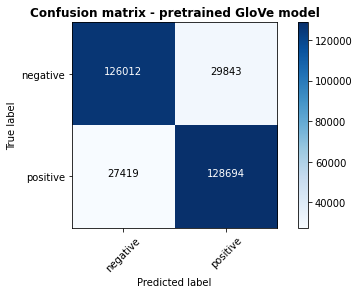

In [ ]:
# Create confusion matrix, classification report
cm = confusion_matrix(y_test, ((y_pred.ravel() > 0.5) + 0))
cr = classification_report(y_test, ((y_pred.ravel() > 0.5) + 0))

classes = ['negative', 'positive']
title = 'Confusion matrix - pretrained GloVe model'

# Call function to plot confusion matrix
plot_confusion_matrix(cm, classes, title)

print(cr)

## <font color=green>8.6 - Check the prediction mistakes</font>

With our best model, we still have **~16% of mistakes**, half of them are false positives (tweets predicted as POSITIVE when their true labels are NEGATIVE).

In [ ]:
pd.set_option("display.max_colwidth", 200)

# Import ORIGINAL data
df = pd.read_csv(src_folder / 'p7_01b_final_df.csv')
df = df[['tweet', 'clean_tweet', 'sentiment']]
df.head()

,tweet,clean_tweet,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",user url w that is a bummer you should got david carr of third day to do it d,0
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cannot update his facebook by texting it and might cry as a result school today also,0
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,user i dived many times for the ball managed to save the rest go out of bounds,0
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,0
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",user no it is not behaving at all i am mad why am i here because i cannot see you all over there,0


In [ ]:
# Retrieve X_test index
idx_list = list(X_test.index.values)

# Filter original data on X_test index
df = df.iloc[idx_list]
df.reset_index(drop=True, inplace=True)

# Display shape and 5 first rows
print(df.shape)
df.head()

(311968, 3)


,tweet,clean_tweet,sentiment
0,Nothing kills a Saturday like a migraine and a fever,nothing kills a saturday like a migraine and a fever,0
1,After a lot of moving is back home in the shire and loving the sunshine,after a lot of moving is back home in the shire and loving the sunshine,1
2,@CoreyCreed: sorry to hear that r u getting any better now?,user sorry to hear that r you getting any better now,0
3,Welcome to our Official Rapid8 Twitter Page,welcome to our official rapid twitter page,1
4,@CarlyAnnMiller every person you know minus meeeee! I couldn't go either so you and I can see it together,user every person you know minus mee i could not go either so you and i can see it together,1


In [ ]:
# Create score DF
scores = pd.DataFrame(y_pred, columns=['score'])

# Concatenate as final DF
df = pd.concat([df, scores], axis=1)

# Create predictions columns
def decode_sentiment(score):
    return 0 if score < 0.5 else 1

df['predictions'] = df['score'].apply(decode_sentiment)

# Create final DF
final_df = df[['tweet', 'clean_tweet', 'sentiment', 'predictions', 'score']]
print(final_df.shape)
final_df.head(10)

(311968, 5)


,tweet,clean_tweet,sentiment,predictions,score
0,Nothing kills a Saturday like a migraine and a fever,nothing kills a saturday like a migraine and a fever,0,0,0.005068
1,After a lot of moving is back home in the shire and loving the sunshine,after a lot of moving is back home in the shire and loving the sunshine,1,1,0.977624
2,@CoreyCreed: sorry to hear that r u getting any better now?,user sorry to hear that r you getting any better now,0,0,0.041695
3,Welcome to our Official Rapid8 Twitter Page,welcome to our official rapid twitter page,1,1,0.988719
4,@CarlyAnnMiller every person you know minus meeeee! I couldn't go either so you and I can see it together,user every person you know minus mee i could not go either so you and i can see it together,1,0,0.444871
5,i am sick! WHYYYYYY im trying so desperately to study! and now i cant breathe! *cries* what cruel and unusual punishment!,i am sick wh i am trying so desperately to study and now i cannot breathe cries what cruel and unusual punishment,0,0,0.004877
6,@AlexAllTimeLow ok then idk. Houston is the luckiest city right now,user ok then i do not know houston is the luckiest city right now,0,1,0.782563
7,@turpentine2009 sitting indoors away from the heat .. far too warm today. Though might to random garden weeding every now &amp; again,user sitting indoors away from the heat far too warm today though might to random garden weeding every now again,1,1,0.628116
8,back to reality!,back to reality,1,0,0.053241
9,sorry you are?. great tune,sorry you are great tune,1,0,0.474753


In [ ]:
# Save to CSV file
final_df.to_csv(src_folder / 'p7_04_model_final_lm.csv', index=False)

In [ ]:
# Check false positive predictions
fp_pred = final_df[(final_df.sentiment == 0) & (final_df.predictions == 1)]
print(fp_pred.shape)
fp_pred.head(10)

(29843, 5)


,tweet,clean_tweet,sentiment,predictions,score
6,@AlexAllTimeLow ok then idk. Houston is the luckiest city right now,user ok then i do not know houston is the luckiest city right now,0,1,0.782563
13,looks like im not having a roast looks like im doing @FrankieTheSats style and pot noodle for me it is xx,looks like i am not having a roast looks like i am doing user style and pot noodle for me it is xx,0,1,0.630801
40,"Is sunburnt Amazing weather for cardiff though, more than barcelona yesterday! GOODTIMES!",is sunburnt amazing weather for cardiff though more than barcelona yesterday goodtimes,0,1,0.725750
41,@jonasbrothers could you maybe do a livechat way earlier? it was like 2AM here. so we couldnt watch it but you are amazing no matter what,user could you maybe do a livechat way earlier it was like am here so we could not watch it but you are amazing no matter what,0,1,0.682348
50,@saaaaaarah15 yeah same its just like we said aswell!,user same it is just like we said aswell,0,1,0.692719
57,"@mymemoirs i was defending my goal, girl went to shoot at goal 1 metre away from me, and the ball hit me straight on the face",user i was defending my goal girl went to shoot at goal metre away from me and the ball hit me straight on the face,0,1,0.606177
65,Having a bagel in BK with the ATWT crew I have to poop http://myloc.me/2s9i,having a bagel in bk with the atwt crew i have to poop url,0,1,0.650878
72,Its a beautyful day my friends...and theres none to do man...still gotta finish dat mothaf*in book.......,it is a beautyful day my friends and there is none to do man still got to finish dat mothaf in book,0,1,0.603565
87,"Herpes be gone! Bet quote of the night, &quot;Unlike Love, Herpes is Forever&quot; on queue: Viruses and Cancer. This is normal saturday = study",herpes be gone bet quote of the night unlike love herpes is forever on queue viruses and cancer this is normal saturday study,0,1,0.506873
90,Taylor Swift Dateline special and the MTV video awards are on at the same time,taylor swift dateline special and the mtv video awards are on at the same time,0,1,0.900639


Let's check specifically the negative labels, predicted as positive with more than 0.9 of confidence score.

In [ ]:
# Check all false positive with score > 0.9
fp_pred[fp_pred.score > 0.9].sample(15)

,tweet,clean_tweet,sentiment,predictions,score
1690,http://twitpic.com/7lgpb - Booo all out of bacardi,url b all out of bacardi,0,1,0.926503
34916,@millionsbyname Jared's wearing a green shirt? *SPARKLY EYES* YEE!! I hear #asylm is highly disorganized hang in there!,user jared s wearing a green shirt sparkly eyes yee i hear hashtag is highly disorganized hang in there,0,1,0.937279
272903,@sardun yeah i agree with you...they're not cosy i know people think they're stylish but i prefer s/thing less slippery!glad you agree!,user i agree with you they are not cosy i know people think they are stylish but i prefer s thing less slippery glad you agree,0,1,0.902767
275901,What up Leah?!!!!!! Come On!!!!!! You have to tweet with me!!!!!!!!,what up leah come on you have to tweet with me,0,1,0.941534
148727,"@RustedParadox yesss, exactly",user ye exactly,0,1,0.919785
86722,@camea ohmyyyy me tooo breakfast is the best hahaha,user ohmy me t breakfast is the best ha,0,1,0.959952
109704,"@theBeerWench wow, hope life isn't all that bad remember hops are just around the corner to help make you happy!",user hope life is not all that bad remember hops are just around the corner to help make you happy,0,1,0.923637
132053,@Ldnshmoo find itttt lovely! thank u xx,user find it lovely thank you xx,0,1,0.980822
140851,Full moons - crazy nights - resting at home w cousin rocio n jess watchin greys georgie!!! Waaah,full moons crazy nights resting at home w cousin rocio n jess watchin greys georgie wh,0,1,0.939002
72062,@belladonna20 to all good things comes an end .. But you can look back at the good times you had with them ((hugs)),user to all good things comes an end but you can look back at the good times you had with them hugs,0,1,0.903593


In [ ]:
# Check all false positive with score > 0.9
fp_pred[fp_pred.score > 0.9].sample(15)

,tweet,clean_tweet,sentiment,predictions,score
74183,Going to meet my best friend chris! ;-) ;-) ;-) ;-) ;-) ;-) ;-) ;-) ;-) ;-) &gt;,going to meet my best friend chris,0,1,0.981511
163161,I googled up remedies for jonzing and reading was one of the suggestions. therefore i'm now reading angels and demons.. it's pretty bunk,i googled up remedies for jonzing and reading was one of the suggestions therefore i am now reading angels and demons it is pretty bunk,0,1,0.911360
157560,@BooshyBAD Ur Funny For That.....how u gonna Play me Lol,user your funny for that how you going to play me,0,1,0.962166
139381,Signed up for twitter,signed up for twitter,0,1,0.927783
55857,I have to go to a granite warehouse all day to pick out counters for my beach house,i have to go to a granite warehouse all day to pick out counters for my beach house,0,1,0.918469
30009,@Liz_Lucy Lol HAIIII LIZZZZ XD When are you getting your internet backk? XD,user hai liz xd when are you getting your internet backk xd,0,1,0.958032
93647,@impeccableswag interesting how u been ghost,user interesting how you been ghost,0,1,0.927003
120595,@malvim It's funny because it's true...,user it is funny because it is true,0,1,0.946746
282534,ready for my little boy to come home from spending time with grandpa and grandma,ready for my little boy to come home from spending time with grandpa and grandma,0,1,0.925210
93444,Just saw The Wrestler - but good,just saw the wrestler but good,0,1,0.950903


In [ ]:
# Check all false positive with score > 0.9
fp_pred[fp_pred.score > 0.9].sample(15)

,tweet,clean_tweet,sentiment,predictions,score
104249,@MrSneakaHead ooooo got too excited,user oo got too excited,0,1,0.939228
214003,@bobbythomas1 but idiotacy and brilliance are interesting companions,user but idiotacy and brilliance are interesting companions,0,1,0.974291
243157,@jseifer recording in the shower sounds great. Maybe the next door will be amplified too Remember to turn shower off,user recording in the shower sounds great maybe the next door will be amplified too remember to turn shower off,0,1,0.926575
266098,@ItsOnAlexa awww man i waz realy excited about asher roth,user w man i waz realy excited about asher roth,0,1,0.932869
96825,"@misterjt http://playspymaster.com/, aka scourge of Twitter",user url aka scourge of twitter,0,1,0.973085
52801,@stickypearls good luck.,user good luck,0,1,0.958814
248884,dog in the proposal...too adorable. work @ 8 but yay for new cameraa,dog in the proposal too adorable work user but for new cameraa,0,1,0.970654
194946,TODAY IS OFFICALLY FATHERS DAY R.I.P DADDY I LOVE,today is offically fathers day r i p daddy i love,0,1,0.917736
243104,"Has finished planing veggies in the garden, beans, spinich, carrots, shallots, caulifower and cabbage. Rhubarb taking over garden",has finished planing veggies in the garden beans spinich carrots shallots caulifower and cabbage rhubarb taking over garden,0,1,0.987720
202376,@amy522 aww me 2 so is it kool ther,user me so is it kool ther,0,1,0.943335


In [ ]:
# Check all false positive with score > 0.9
fp_pred[fp_pred.score > 0.9].values.tolist()

[['Taylor Swift Dateline special and the MTV video awards are on at the same time ',
  'taylor swift dateline special and the mtv video awards are on at the same time',
  0,
  1,
  0.9006392359733582],
 ['@Everydaydisney it was perfect 4 me ',
  'user it was perfect me',
  0,
  1,
  0.9220073223114014],
 ['@covergirlnkotb okee.  try textin me when its up again',
  'user okee try textin me when it is up again',
  0,
  1,
  0.9193505048751831],
 ["@stanmorePhoenix very welcome. When r u next busking? I was on Pitt st on sat but don't remember seeing anyone busking ",
  'user very welcome when r you next busking i was on pitt st on sat but do not remember seeing anyone busking',
  0,
  1,
  0.9041913151741028],
 ["The internetz is busy this Friday morning: Google Wave, Hulu Desktop, Microsoft's Bing, Tweetie Update and Megan Fox as Wonder Woman ",
  'the internetz is busy this friday morning google wave hulu desktop microsoft s bing tweetie update and megan fox as wonder woman',
  0,
  1,

We have found different reasons which could decrease the capability of our model to predict accurately:
- **an error of initial labelling** (tweets tagged as negative, but seems to be positive);
- **a bad detection of sarcasm**;
- **the misunderstanding of other languages**;
- **a tweet with mix of emotions**: indeed, sentiments can be mixed, not only positive or negative.

# <font color=salmon>CONCLUSION</font>

Here are the sorted results of our advanced models on cleaned (with Stop Words), Stemmed and Lemmetized Tweet, including the testing of GloVe+LSTM model on the full dataframe.

In [ ]:
clean_model_results = pd.read_csv(src_folder / "p7_04_model_results_cl.csv")
clean_model_results = clean_model_results.sort_values(by='AUC_Score', ascending=False)
clean_model_results

,Model,False positives,AUC_Score,Accuracy,Loss,Fit_time,Eval_time,Predict_time
6,Glove (full DF),24499,91.580%,83.556%,37.130%,174.9,10.3,19.9
4,GloVe +LSTM,54,79.405%,72.500%,62.565%,4.7,0.1,0.5
3,Word2Vec +LSTM,111,73.094%,57.812%,71.840%,5.5,0.1,0.9
1,LSTM,87,68.042%,59.375%,69.497%,7.1,0.1,0.5
5,BERT,38,66.425%,61.719%,65.152%,38.5,0.6,3.9
2,Bi-LSTM,122,65.731%,57.187%,79.331%,7.8,0.1,0.9
0,Simple RNN,99,57.612%,53.438%,75.649%,7.5,0.1,0.2


In [ ]:
stem_model_results = pd.read_csv(src_folder / "p7_04_model_results_sm.csv")
stem_model_results = stem_model_results.sort_values(by='AUC_Score', ascending=False)
stem_model_results

,Model,False positives,AUC_Score,Accuracy,Loss,Fit_time,Eval_time,Predict_time
6,Glove (full DF),29303,89.037%,80.795%,42.303%,150.0,4.7,15.6
3,Word2Vec +LSTM,100,75.733%,63.125%,68.884%,3.8,0.1,0.7
1,LSTM,83,75.111%,64.062%,69.772%,5.7,0.1,0.4
4,GloVe +LSTM,53,74.997%,68.437%,68.806%,3.4,0.1,0.3
2,Bi-LSTM,111,71.718%,58.438%,71.898%,5.8,0.1,0.7
5,BERT,0,62.302%,51.172%,78.047%,34.0,0.6,2.9
0,Simple RNN,119,57.229%,52.188%,76.632%,6.8,0.1,0.2


In [ ]:
lemma_model_results = pd.read_csv(src_folder / "p7_04_model_results_lm.csv")
lemma_model_results = lemma_model_results.sort_values(by='AUC_Score', ascending=False)
lemma_model_results

,Model,False positives,AUC_Score,Accuracy,Loss,Fit_time,Eval_time,Predict_time
6,Glove (full DF),29843,89.812%,81.645%,40.549%,145.1,4.7,15.8
4,GloVe +LSTM,46,77.884%,72.812%,65.494%,3.5,0.1,0.4
2,Bi-LSTM,17,76.235%,66.250%,69.596%,5.6,0.1,0.7
3,Word2Vec +LSTM,105,73.460%,61.875%,71.015%,4.7,0.1,0.7
1,LSTM,108,71.757%,59.062%,70.933%,3.9,0.1,0.4
5,BERT,107,64.335%,57.031%,68.499%,31.8,0.6,2.9
0,Simple RNN,161,57.082%,48.438%,77.619%,4.1,0.1,0.2


As a remainder, we load again the results of our previously tested models:
- Azure ML Studio pipelines built in the Designer;
- Azure Sentiment API, one of Text Analytics solutions included in Azure Cognitive Collections of resources.

In [ ]:
# Load result
studio = pd.read_csv(src_folder / 'p7_03_model_results.csv')
studio = studio.sort_values(by='AUC_Score', ascending=False)
studio

,Model,Predict_time,AUC_Score,Accuracy
1,Studio - N-grams extraction,103.4,78.400%,70.600%
0,Studio - Feat. hashing,81.5,70.200%,63.400%


In [ ]:
# Load result
sent_api = pd.read_csv(src_folder / 'p7_02_model_results.csv')
sent_api = sent_api.sort_values(by='AUC_Score', ascending=False)
sent_api

,Model,Predict_time,AUC_Score,Accuracy
1,Cleaned tweets,192.2,75.989%,75.949%
2,Lemmatized tweets,184.0,75.380%,75.319%
0,Original tweets,186.1,74.349%,74.335%


If we focus on **AUC Score**:
- the minimum comes from Simple RNN: 53.96%;
- the maximum comes from GloVe+LSTM: 79.02%.

For the **Accuracy**:
- the minimun comes from Simple RNN: 53.96%;
- the maximum comes from Cleaned tweets	: 75.95%.

Thus, our best model is **pre-trained GloVe embeddings with 200-dimensions vector**: this is the one we will deploy through web service with Azure Machine Learning.

# <font color=salmon>RESOURCES</font>

The following websites were very useful to understand the logic behind words embeddings and Tensorflow tools:
- https://www.kaggle.com/bertcarremans/using-word-embeddings-for-sentiment-analysis
- https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences